## 🚲 2023 서울 · 경기 자전거 사고 건수 & 보행자 혼합비율 분석

**목표**  
- **서울:** `bicycle_accidents_2023.xlsx`에서 자치구별 자전거 **사고건수(건)** 산출  
- **경기:** `bicycle_accidents_hotspot_status.xlsx`에서 시군별 **총사고건수(핫스팟 발생건수)** 산출  
- 두 지역의 **보행자 혼합비율(%)**과 **자전거 사고 건수(건/km)** 간의 관계를  
  **회귀분석(OLS)** 및 **시각화**로 비교  

> ⚠️ 행정단위가 다름 — *서울=자치구*, *경기=시·군*  
> 본 분석은 **분포 차이 검정(범주형 더미 회귀)** 관점에서 수행됩니다.

---

### 📈 분석 주요 내용
1. **자전거 사고 건수(건/km)** — 지역별 도로 총연장 대비 사고 빈도  
2. **보행자 혼합비율(%)** — 보행자겸용 자전거도로가 차지하는 비중  
3. **서울 vs 경기 비교**  
   - 평균 혼합비율 및 사고 건수  
   - 지역별 막대그래프 시각화  
4. **회귀분석(OLS)**  
   - 보행자 혼합비율이 자전거 사고 건수에 미치는 영향 분석  
   - 서울·경기 구분 더미변수(`is_seoul`) 포함

##### 자전거 사고 건수 & 총 사고 건수

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

import platform
import re

# ✅ 한글 폰트 자동 설정
if platform.system() == 'Windows':      # 윈도우
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':     # 맥
    plt.rcParams['font.family'] = 'AppleGothic'
else:                                   # 리눅스 (Colab 등)
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 데이터 로드
seoul_raw = pd.read_excel("../data/bicycle_accidents_2023.xlsx", header=[0,1])
gg_raw = pd.read_excel("../data/bicycle_accidents_hotspot_status.xlsx")

c:\Users\cib03\anaconda3\envs\sesac-env\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [84]:
display(seoul_raw)

자치구별(1)  자치구별(2)           2023                                    \
    자치구별(1)  자치구별(2) 자전거 가해운전자 교통사고 자전거 가해운전자 교통사고.1 자전거 가해운전자 교통사고.2   
0   자치구별(1)  자치구별(2)       발생건수 (건)         사망자수 (명)         부상자수 (명)   
1        합계       소계           1531                6             1698   
2       NaN      종로구             21                -               23   
3       NaN       중구             24                -               25   
4       NaN      용산구             32                1               34   
5       NaN      성동구             49                -               58   
6       NaN      광진구             38                -               40   
7       NaN     동대문구            119                -              130   
8       NaN      중랑구             88                -              101   
9       NaN      성북구             33                -               35   
10      NaN      강북구             45                -               47   
11      NaN      도봉구             36                -               40   
12      NaN      노원구             77                1               84   
13      NaN      은평구             32                -               39   
14      NaN     서대문구             23                -               24   
15      NaN      마포구             37                1               37   
16      NaN      양천구             67                1               73   
17      NaN      강서구             76                -               81   
18      NaN      구로구             78                -               85   
19      NaN      금천구             38                -               46   
20      NaN     영등포구            150                1              169   
21      NaN      동작구             48                -               52   
22      NaN      관악구             18                -               18   
23      NaN      서초구             47                -               50   
24      NaN      강남구            105                -              124   
25      NaN      송파구            181                1              208   
26      NaN      강동구             69                -               75   

                                                     
   자전거 피해운전자 교통사고 자전거 피해운전자 교통사고.1 자전거 피해운전자 교통사고.2  
0        발생건수 (건)         사망자수 (명)         부상자수 (명)  
1            1319                9             1434  
2              18                -               19  
3              19                -               20  
4              30                -               32  
5              45                1               48  
6              31                -               35  
7             102                1              110  
8              73                1               79  
9              26                1               32  
10             22                -               23  
11             37                1               37  
12             78                1               79  
13             38                -               38  
14             20                -               22  
15             47                1               51  
16             51                -               58  
17             80                -               83  
18             58                -               63  
19             24                1               27  
20             97                -              109  
21             34                -               38  
22             29                1               30  
23             34                -               37  
24             67                -               79  
25            178                -              199  
26             81                -               86

In [85]:
display(gg_raw)

,시군명,구/읍면동명,사고년도,사고유형구분,다발지역FID,다발지역ID,법정동코드,위치코드,시도시군구명,사고지역위치명,발생건수,사상자수,사망자수,중상자수,경상자수,부상자수,위도,경도,사고다발지역폴리곤정보
0,수원시,팔달구,2023,자전거사고다발지,6930172,2024046,4111513700,41115001,경기 수원시 팔달구1,경기 수원시 팔달구 고등동(육교사거리 부근),4,4,0,3,1,0,37.269513,126.998124,"{""type"":""Polygon"",""coordinates"":[[[126.9999206..."
1,김포시,운양동,2023,자전거사고다발지,6930133,2024046,4157010300,41570002,경기 김포시2,경기 김포시 운양동(김포한강로사거리 부근),4,4,0,1,3,0,37.649521,126.675285,"{""type"":""Polygon"",""coordinates"":[[[126.6770818..."
2,시흥시,정왕동,2023,자전거사고다발지,6930021,2024046,4139013200,41390001,경기 시흥시1,경기 시흥시 정왕동(군자2교사거리 부근),4,4,0,2,2,0,37.343852,126.732894,"{""type"":""Polygon"",""coordinates"":[[[126.7346910..."
3,안산시,단원구,2023,자전거사고다발지,6930062,2024046,4127310700,41273002,경기 안산시 단원구2,경기 안산시 단원구 초지동(구생약국 부근),5,5,0,2,2,1,37.308343,126.816112,"{""type"":""Polygon"",""coordinates"":[[[126.8179081..."
4,안산시,단원구,2023,자전거사고다발지,6930095,2024046,4127310100,41273003,경기 안산시 단원구3,경기 안산시 단원구 고잔동(몽차우 부근),5,5,0,1,3,1,37.308888,126.829389,"{""type"":""Polygon"",""coordinates"":[[[126.8311851..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,오산시,오산동,2012,자전거사고다발지,160647,2013099,4137010100,41370001,경기도 오산시1,경기도 오산시 오산동(어린이보호구역 부근),4,4,0,2,2,0,37.149648,127.065486,"{""type"":""Polygon"",""coordinates"":[[[127.0670779..."
784,의정부시,의정부동,2012,자전거사고다발지,160323,2013099,4115010100,41150001,경기도 의정부시1,경기도 의정부시 의정부동((KT입구) 부근),5,5,0,4,1,0,37.733739,127.043351,"{""type"":""Polygon"",""coordinates"":[[[127.0449553..."
785,의정부시,금오동,2012,자전거사고다발지,160322,2013099,4115010900,41150002,경기도 의정부시2,경기도 의정부시 금오동(양수교 부근),5,5,2,3,0,0,37.744713,127.053023,"{""type"":""Polygon"",""coordinates"":[[[127.0546279..."
786,평택시,이충동,2012,자전거사고다발지,160344,2013099,4122010900,41220001,경기도 평택시1,경기도 평택시 이충동(반지마을주공3단지 부근),4,4,0,2,2,0,37.057297,127.067328,"{""type"":""Polygon"",""coordinates"":[[[127.0689181..."


In [86]:
# 필요한 컬럼만 선택 (KeyError 방지용 구조 확인)
seoul_df = seoul_raw[[
    ('자치구별(1)', '자치구별(1)'),
    ('자치구별(2)', '자치구별(2)'),
    ('2023', '자전거 가해운전자 교통사고'),
    ('2023', '자전거 피해운전자 교통사고')
]].copy()

seoul_df.columns = ['광역시도','시군구','가해_건수','피해_건수']
for c in ['가해_건수','피해_건수']:
    seoul_df[c] = pd.to_numeric(seoul_df[c], errors='coerce')

seoul_df['자전거사고건수'] = seoul_df[['가해_건수','피해_건수']].sum(axis=1, min_count=1)

print(f"전처리 완료 — 예시 {len(seoul_df)}행")
display(seoul_df)

전처리 완료 — 예시 27행


,광역시도,시군구,가해_건수,피해_건수,자전거사고건수
0,자치구별(1),자치구별(2),NaN,NaN,NaN
1,합계,소계,1531.0,1319.0,2850.0
2,NaN,종로구,21.0,18.0,39.0
3,NaN,중구,24.0,19.0,43.0
4,NaN,용산구,32.0,30.0,62.0
5,NaN,성동구,49.0,45.0,94.0
6,NaN,광진구,38.0,31.0,69.0
7,NaN,동대문구,119.0,102.0,221.0
8,NaN,중랑구,88.0,73.0,161.0
9,NaN,성북구,33.0,26.0,59.0


In [87]:
# 경기: 시군별 총사고건수 (핫스팟 발생건수 합)
cols = gg_raw.columns.astype(str).tolist()
if '시군명' in cols:
    gg_group = gg_raw.groupby('시군명', as_index=False)['발생건수'].sum()
    gg_group.rename(columns={'시군명': '행정단위', '발생건수': '총사고건수'}, inplace=True)
else:
    tmp = gg_raw.copy()
    tmp['행정단위'] = tmp['시도시군구명'].astype(str).str.replace('^경기\s*', '', regex=True)
    tmp['행정단위'] = tmp['행정단위'].apply(lambda s: ' '.join(str(s).split()[:1]) if isinstance(s,str) else s)
    gg_group = tmp.groupby('행정단위', as_index=False)['발생건수'].sum()
    gg_group.rename(columns={'발생건수': '총사고건수'}, inplace=True)

gg_group['지역'] = '경기'
print(f"경기 데이터 {len(gg_group)}개 행")
display(gg_group)

경기 데이터 30개 행


,행정단위,총사고건수,지역
0,가평군,8,경기
1,고양시,410,경기
2,과천시,7,경기
3,광명시,116,경기
4,광주시,4,경기
5,구리시,62,경기
6,군포시,48,경기
7,김포시,77,경기
8,남양주시,56,경기
9,동두천시,28,경기


In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import platform

# 폰트(한글 깨짐 방지)
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 원본(멀티헤더)에서 필요한 컬럼 안전 탐색
cols = list(seoul_raw.columns)

def pick_col(level0_contains=None, level1_contains=None):
    cand = []
    for c in cols:
        if not isinstance(c, tuple) or len(c) < 2:
            continue
        ok0 = (level0_contains is None) or (level0_contains in str(c[0]))
        ok1 = (level1_contains is None) or (level1_contains in str(c[1]))
        if ok0 and ok1:
            cand.append(c)
    if not cand:
        return None
    return cand[0]

metro_col = pick_col('자치구별(1)', '자치구별(1)')  # 광역시도
gu_col    = pick_col('자치구별(2)', '자치구별(2)')  # 시군구
ga_col    = pick_col('2023', '자전거 가해운전자 교통사고')
pi_col    = pick_col('2023', '자전거 피해운전자 교통사고')

if any(x is None for x in [gu_col, ga_col, pi_col]):
    raise ValueError("서울 원본에서 필요한 컬럼을 찾지 못했습니다. 헤더 구조를 확인하세요.")

# DataFrame 구성
tmp = pd.DataFrame({
    "광역시도": seoul_raw[metro_col] if metro_col else np.nan,
    "시군구":   seoul_raw[gu_col],
    "가해_건수": pd.to_numeric(seoul_raw[ga_col], errors='coerce'),
    "피해_건수": pd.to_numeric(seoul_raw[pi_col], errors='coerce'),
})
tmp["자전거사고건수"] = tmp[["가해_건수","피해_건수"]].sum(axis=1, min_count=1)

# ‘서울’ 필터(유연) + 합계/소계 제거
pattern = r"(서울|서울특별시|서울시)"
before = len(tmp)
has_metro = tmp["광역시도"].notna().any()

if has_metro and tmp["광역시도"].astype(str).str.contains(pattern).any():
    tmp = tmp[tmp["광역시도"].astype(str).str.contains(pattern, na=False)]
else:
    # 시트가 서울 전용이거나 광역시도 칼럼이 비어있다면 강제로 서울 라벨로 간주
    tmp["광역시도"] = "서울"

tmp = tmp[tmp["시군구"].notna() & ~tmp["시군구"].astype(str).str.contains("합계|소계")]
after = len(tmp)

# 서울 집계
seoul_by_gu = (
    tmp.groupby("시군구", as_index=False)["자전거사고건수"]
    .sum()
    .sort_values("자전거사고건수", ascending=False)
)
print(f"서울 재구성 완료: {before} → {after} rows, 그룹화 후 {len(seoul_by_gu)}개 자치구")
display(seoul_by_gu)

서울 재구성 완료: 27 → 26 rows, 그룹화 후 26개 자치구


C:\Users\cib03\AppData\Local\Temp\ipykernel_29208\1747477355.py:53: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if has_metro and tmp["광역시도"].astype(str).str.contains(pattern).any():


,시군구,자전거사고건수
17,송파구,359.0
19,영등포구,247.0
10,동대문구,221.0
0,강남구,172.0
25,중랑구,161.0
3,강서구,156.0
8,노원구,155.0
1,강동구,150.0
6,구로구,136.0
18,양천구,118.0


지역 고유값: ['서울' '경기']


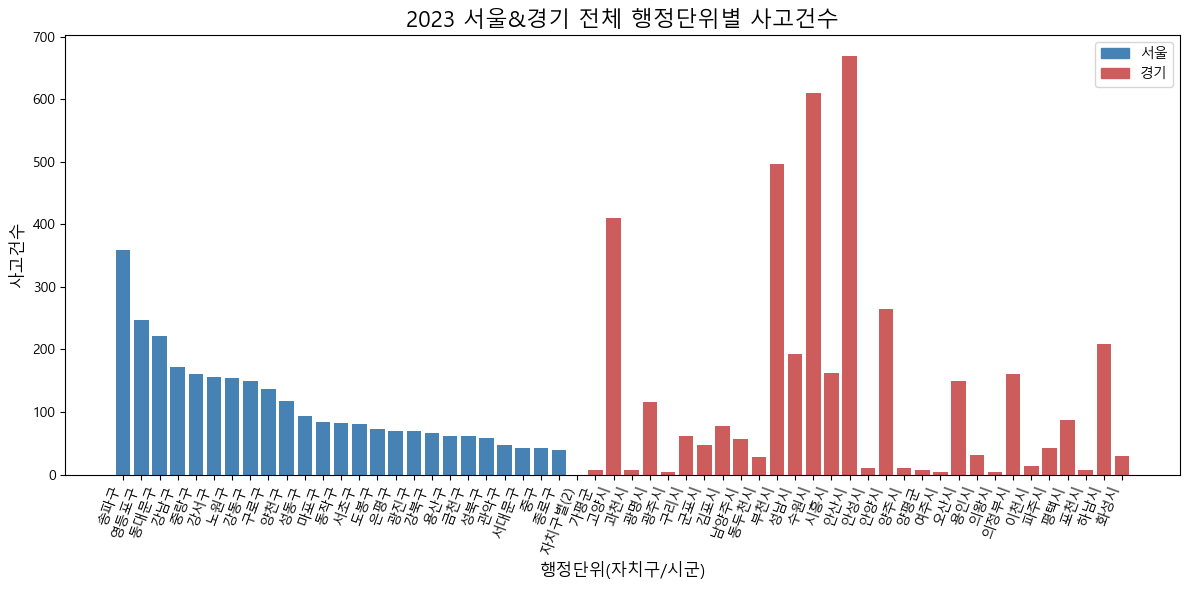

In [89]:
# 서울/경기 결합
seoul_df_all = seoul_by_gu.copy()
seoul_df_all["지역"] = "서울"
seoul_df_all.rename(columns={"시군구":"행정단위", "자전거사고건수":"사고건수"}, inplace=True)

gg_df_all = gg_group.copy()
gg_df_all["지역"] = "경기"
gg_df_all.rename(columns={"행정단위":"행정단위", "총사고건수":"사고건수"}, inplace=True)

combined_all = pd.concat(
    [seoul_df_all[["행정단위","사고건수","지역"]],
    gg_df_all[["행정단위","사고건수","지역"]]],
    ignore_index=True
)

# 지역명 정규화(혹시 모를 변형 표기 대비)
combined_all["지역"] = combined_all["지역"].astype(str)
combined_all["지역"] = combined_all["지역"].str.replace(r"서울.*","서울", regex=True)
combined_all["지역"] = combined_all["지역"].str.replace(r"경기.*","경기", regex=True)

print("지역 고유값:", combined_all["지역"].unique())

# 색상 배열 생성
colors = np.where(combined_all["지역"]=="서울", "steelblue", "indianred")

# 플롯
plt.figure(figsize=(12, 6))
plt.bar(combined_all["행정단위"], combined_all["사고건수"], color=colors)
plt.title("2023 서울&경기 전체 행정단위별 사고건수", fontsize=16)
plt.xlabel("행정단위(자치구/시군)", fontsize=12)
plt.ylabel("사고건수", fontsize=12)
plt.xticks(rotation=70, ha="right")

from matplotlib.patches import Patch
plt.legend(handles=[Patch(color="steelblue", label="서울"),
                    Patch(color="indianred", label="경기")])
plt.tight_layout()
plt.show()

,지역,공식통계_가해운전자기준(건)
0,서울,1531
1,경기,1469


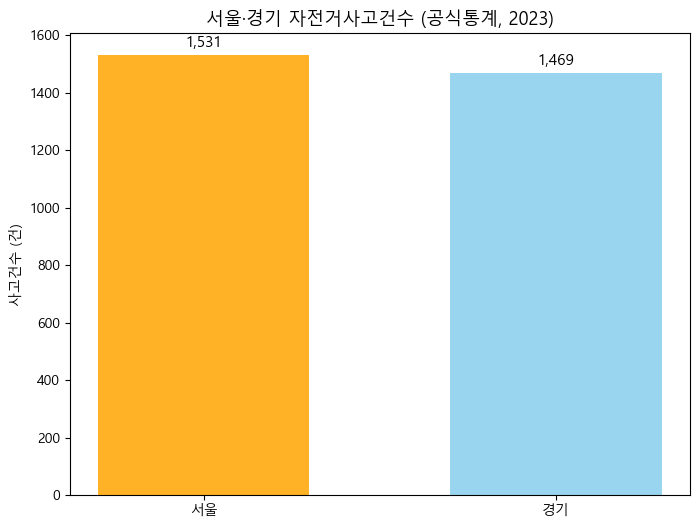

In [90]:
# seoul_total, gg_total 자동 계산 포함
seoul_total = seoul_df['자전거사고건수'].sum() if 'seoul_df' in globals() else 0
gg_total = gg_group['총사고건수'].sum() if 'gg_group' in globals() else 0

# 공식 통계 비교 (출처: 행정안전부·CLIK 2023)
official = pd.DataFrame({
    '지역': ['서울', '경기'],
    '공식통계_가해운전자기준(건)': [1531, 1469]
})

display(official)

# ✅ 시각화 (막대 크기 균일하게 설정)
colors = ['orange', 'skyblue']  # 서울=오렌지, 경기=하늘색

plt.figure(figsize=(8, 6))
bars = plt.bar(
    official['지역'],
    official['공식통계_가해운전자기준(건)'],
    color=colors,
    alpha=0.85,
    width=0.6  # ✅ 막대 두께 일정하게 고정
)

plt.title('서울·경기 자전거사고건수 (공식통계, 2023)', fontsize=13)
plt.ylabel('사고건수 (건)')

# 막대 위에 수치 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 15,
            f'{int(height):,}', ha='center', va='bottom', fontsize=11)

##### 보행자 혼합비율

In [91]:
# 서울·경기 보행자도로비율 & 자전거 사고율 통합 회귀분석 (서울 복원 완전판)

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import re

# ✅ 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ✅ 데이터 불러오기
road_stat = pd.read_excel("../data/bicycle_road_statistics.xlsx")
road_lane = pd.read_excel("../data/bicycle_lane_status_2023.xlsx")
acc_seoul = pd.read_excel("../data/bicycle_accidents_2023.xlsx")
acc_hotspot = pd.read_excel("../data/bicycle_accidents_hotspot_status.xlsx")

# ✅ 도로 데이터 통합 (광역 + 시군구 단위)
road_stat = road_stat.rename(columns={'시군명': '지역명'})
road_lane = road_lane.rename(columns={'시군명': '지역명'})
road_df = pd.concat([road_stat, road_lane], ignore_index=True)
road_df.drop_duplicates(subset=['지역명'], inplace=True)
road_df = road_df.rename(columns={'지역명': '시군명'})

# ✅ 시군명 정규화 (서울/경기 모두 포함)
road_df['시군명'] = (
    road_df['시군명'].astype(str)
    .str.replace('서울특별시', '').str.replace('서울시', '').str.replace('서울 ', '').str.replace('서울', '')
    .str.replace('경기도', '').str.replace('경기 ', '').str.replace('경기', '')
    .apply(lambda x: re.sub(r'[^가-힣]', '', x)).str.strip()
)

# ✅ 전체연장 및 보행자도로비율 계산
road_df['전체연장(km)'] = road_df[['전용도로연장(km)', '보행자겸용도로연장(km)', '전용차로연장(km)', '자전거우선도로연장(km)']].sum(axis=1)
road_df['보행자도로비율(%)'] = (road_df['보행자겸용도로연장(km)'] / road_df['전체연장(km)'] * 100).round(2)

# ✅ 서울 사고 데이터
acc_seoul = acc_seoul.rename(columns={'자치구별(2)': '시군명'})
acc_seoul = acc_seoul.iloc[3:, :]
acc_seoul.columns = ['자치구별(1)', '시군명', '발생건수', '사망자수', '부상자수', '발생건수2', '사망자수2', '부상자수2']
acc_seoul = acc_seoul[['시군명', '발생건수']]
acc_seoul['발생건수'] = pd.to_numeric(acc_seoul['발생건수'], errors='coerce')
acc_seoul['시군명'] = (
    acc_seoul['시군명'].astype(str)
    .str.replace('서울특별시', '').str.replace('서울시', '').str.replace('서울 ', '').str.replace('서울', '')
    .apply(lambda x: re.sub(r'[^가-힣]', '', x)).str.strip()
)
acc_seoul['지역'] = '서울'

# ✅ 경기 사고다발지 데이터
id_candidates = ['사고다발지역ID', '다발지역ID', '사고지역위치명']
id_col = None
for c in id_candidates:
    if c in acc_hotspot.columns:
        id_col = c
        break
if id_col is None:
    id_col = acc_hotspot.columns[1]

acc_hotspot['시군명'] = acc_hotspot['시군명'].astype(str).apply(lambda x: re.sub(r'[^가-힣]', '', x)).str.strip()
acc_hotspot_count = acc_hotspot.groupby('시군명')[id_col].nunique().reset_index(name='사고다발지수')
acc_hotspot_count['지역'] = '경기'

# ✅ 데이터 병합
seoul_merge = pd.merge(road_df, acc_seoul, on='시군명', how='inner')
seoul_merge['사고율(건/km)'] = (seoul_merge['발생건수'] / seoul_merge['전체연장(km)']).round(4)

gyeonggi_merge = pd.merge(road_df, acc_hotspot_count, on='시군명', how='inner')
gyeonggi_merge['사고율(건/km)'] = (gyeonggi_merge['사고다발지수'] / gyeonggi_merge['전체연장(km)']).round(4)

merged = pd.concat([
    seoul_merge[['시군명','지역','보행자도로비율(%)','사고율(건/km)']], 
    gyeonggi_merge[['시군명','지역','보행자도로비율(%)','사고율(건/km)']]
], ignore_index=True)

print(f"✅ 병합된 전체 지역 수: {len(merged)}개")
print("✅ 지역 분포:", merged['지역'].value_counts().to_dict())
display(merged)

✅ 병합된 전체 지역 수: 30개
✅ 지역 분포: {'경기': 30}


c:\Users\cib03\anaconda3\envs\sesac-env\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\cib03\anaconda3\envs\sesac-env\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,시군명,지역,보행자도로비율(%),사고율(건/km)
0,가평군,경기,52.76,0.0350
1,고양시,경기,84.57,0.0278
2,과천시,경기,98.74,0.0587
3,광명시,경기,100.00,0.1403
4,광주시,경기,51.12,0.0148
5,구리시,경기,99.53,0.1068
6,군포시,경기,100.00,0.0714
7,김포시,경기,92.86,0.0433
8,남양주시,경기,96.26,0.0274
9,동두천시,경기,83.78,0.0737


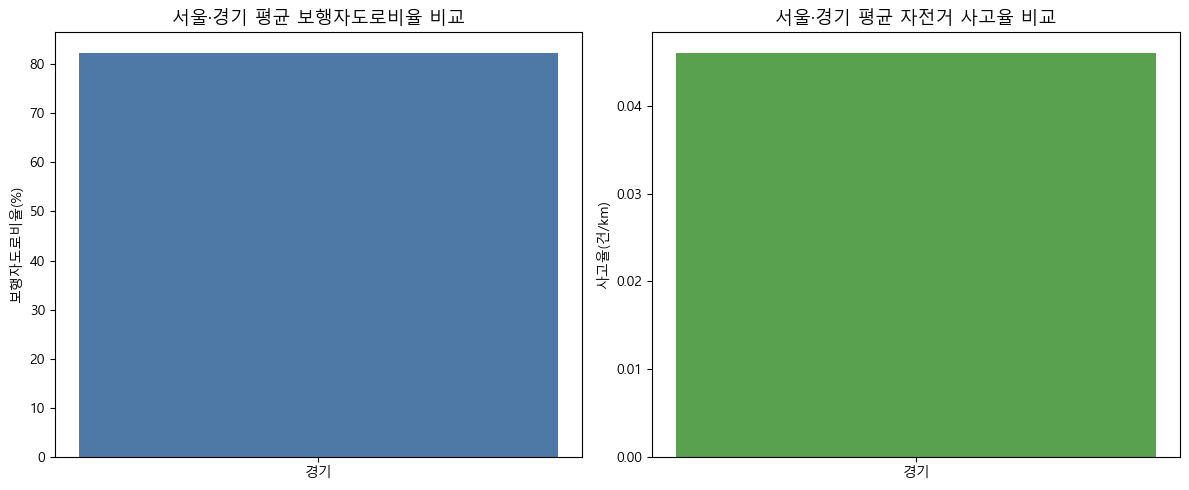

In [92]:
# ✅ 서울·경기 평균 비교 (두 그래프 나란히 표시)
region_mean = merged.groupby('지역')[['보행자도로비율(%)','사고율(건/km)']].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 왼쪽: 보행자도로비율
axes[0].bar(region_mean['지역'], region_mean['보행자도로비율(%)'], color=['#4e79a7','#e15759'])
axes[0].set_title('서울·경기 평균 보행자도로비율 비교', fontsize=13)
axes[0].set_ylabel('보행자도로비율(%)')

# 오른쪽: 사고율
axes[1].bar(region_mean['지역'], region_mean['사고율(건/km)'], color=['#59a14f','#f28e2b'])
axes[1].set_title('서울·경기 평균 자전거 사고율 비교', fontsize=13)
axes[1].set_ylabel('사고율(건/km)')

plt.tight_layout()
plt.show()

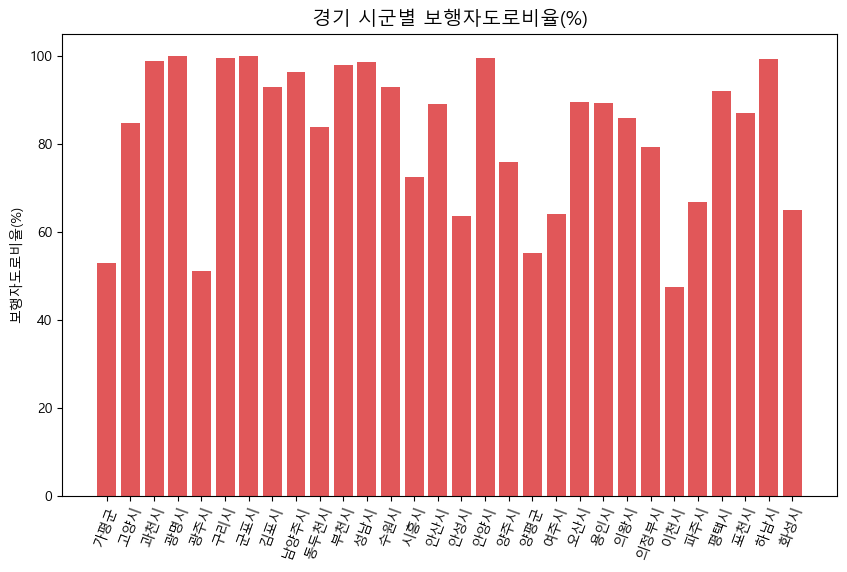

📊 회귀분석 가능 지역 수: 30개


In [93]:
# ✅ 경기 시군별 상세 그래프
if '경기' in merged['지역'].unique():
    gyeonggi_df = merged[merged['지역'] == '경기'].copy()
    
    plt.figure(figsize=(10,6))
    plt.bar(gyeonggi_df['시군명'], gyeonggi_df['보행자도로비율(%)'], color='#e15759')
    plt.title('경기 시군별 보행자도로비율(%)', fontsize=14)
    plt.xticks(rotation=70)
    plt.ylabel('보행자도로비율(%)')
    plt.show()

# ✅ 회귀분석
reg_df = merged.dropna(subset=['보행자도로비율(%)','사고율(건/km)']).copy()
print(f"📊 회귀분석 가능 지역 수: {len(reg_df)}개")